In [60]:
!pwd

/content/drive/My Drive/nmAI/ass2


In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Tiền xử lý dữ liệu 

In [65]:
import os, re, nltk
nltk.download('stopwords')
from nltk import corpus
from numpy.lib.function_base import vectorize
import pandas as pd
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:


class Email:
    def __init__(self, content, label):
        self.content = content
        self.label = label
        self.preprocessing()

    def preprocessing(self):
        self.content = self.content.lower()
        for word in stopwords.words('english'):
            self.content = re.sub(' ' + word + ' ',  ' ', self.content)
        self.content = re.sub(r'\n', ' ', self.content)
        self.content = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'MailID', self.content)
        self.content = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'Links', self.content)
        self.content = re.sub(r'\d+(\.\d+)?', 'numbers', self.content)
        self.content = re.sub(r"[^a-zA-Z0-9]+", " ", self.content)
        self.content = re.sub(r'\s+', ' ', self.content)
        self.content = self.content.strip()

    @staticmethod
    def read():
        if not os.path.exists('messages.csv'):
            return []
        df = pd.read_csv('messages.csv').dropna()
        return list(map(lambda data: Email(data[0], data[1]), zip(df['subject'] + df['message'], df['label'])))

    @staticmethod
    def readTrainTestSplit():
        data = Email.read()
        df = pd.DataFrame()
        df['message'] = [email.content for email in data]
        f = feature_extraction.text.CountVectorizer()
        df['label'] = [email.label for email in data]
        return train_test_split(f.fit_transform(df['message']), df['label'], test_size=0.2, random_state=225, stratify=df['label'])
        
X_train, X_test, Y_train, Y_test = Email.readTrainTestSplit()


###SVM

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

In [68]:
# kernel = 'rbf'
model1 = SVC(C=1.0, kernel='rbf')
model1.fit(X_train,Y_train)
y_pred = model1.predict(X_test)
print("Accuracy : ", accuracy_score(y_pred,Y_test))
print("Precision : ", precision_score(y_pred,Y_test, average ='weighted'))
print("Recall : ", recall_score(y_pred,Y_test, average ='weighted'))

Accuracy :  0.9241622574955908
Precision :  0.9588539907688843
Recall :  0.9241622574955908


In [69]:
# kernel = 'linear'
model3 = SVC(C=1.0, kernel='linear')
model3.fit(X_train,Y_train)
y_pred = model3.predict(X_test)
print("Accuracy : ", accuracy_score(y_pred,Y_test))
print("Precision : ", precision_score(y_pred,Y_test, average ='weighted'))
print("Recall : ", recall_score(y_pred,Y_test, average ='weighted'))

Accuracy :  0.9947089947089947
Precision :  0.9946976896506833
Recall :  0.9947089947089947


###Naive Baye

In [70]:
import numpy as np
from sklearn import feature_extraction, model_selection, naive_bayes, metrics

We train different bayes models changing the regularization parameter $\alpha$. <p>

In [71]:
# Chọn alpha

list_alpha = np.arange(1/100000, 20, 0.1)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, Y_train)
    score_train[count] = bayes.score(X_train, Y_train)
    score_test[count]= bayes.score(X_test, Y_test)
    recall_test[count] = metrics.recall_score(Y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(Y_test, bayes.predict(X_test))
    count = count + 1 

Let's see the first 10 learning models and their metrics!

In [72]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,1.000000,0.998236,0.989362,1.000000
1,0.10001,0.998233,0.991182,1.000000,0.949495
2,0.20001,0.998233,0.991182,1.000000,0.949495
3,0.30001,0.998233,0.991182,1.000000,0.949495
4,0.40001,0.998233,0.991182,1.000000,0.949495
5,0.50001,0.997350,0.991182,1.000000,0.949495
6,0.60001,0.997350,0.991182,1.000000,0.949495
7,0.70001,0.997350,0.991182,1.000000,0.949495
8,0.80001,0.997350,0.991182,1.000000,0.949495
9,0.90001,0.997350,0.991182,1.000000,0.949495


I select the model with the most test precision

In [73]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             0.000010
Train Accuracy    1.000000
Test Accuracy     0.998236
Test Recall       0.989362
Test Precision    1.000000
Name: 0, dtype: float64

**My best model does not produce any false positive, which is our goal.** <p>
Let's see if there is more than one model with 100% precision !

In [74]:
models[models['Test Precision']==1].head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,1.000000,0.998236,0.989362,1.0
97,9.70001,0.983216,0.975309,0.851064,1.0
98,9.80001,0.982774,0.975309,0.851064,1.0
99,9.90001,0.982332,0.975309,0.851064,1.0
100,10.00001,0.982332,0.975309,0.851064,1.0
101,10.10001,0.981449,0.973545,0.840426,1.0
102,10.20001,0.981007,0.971781,0.829787,1.0
103,10.30001,0.980565,0.971781,0.829787,1.0
104,10.40001,0.980124,0.971781,0.829787,1.0
105,10.50001,0.979240,0.971781,0.829787,1.0


Between these models with the highest possible precision, we are going to select which has more test accuracy.

In [75]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, Y_train)
models.iloc[best_index, :]

alpha             0.000010
Train Accuracy    1.000000
Test Accuracy     0.998236
Test Recall       0.989362
Test Precision    1.000000
Name: 0, dtype: float64

Confusion matrix with naive bayes classifier

In [76]:
m_confusion_test = metrics.confusion_matrix(Y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,473,0
Actual 1,1,93


### Neural


In [77]:
#import các thư viện cần thiết 

import tensorflow.keras as keras
from keras.models import  Sequential    
from keras.layers import Dense ,Conv1D,MaxPooling1D,Flatten
import matplotlib.pyplot as plt

In [78]:
print(type(X_train))
print(X_train)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 24)	1
  (0, 1141)	1
  (0, 1153)	1
  (0, 1378)	1
  (0, 1724)	1
  (0, 1854)	1
  (0, 1910)	2
  (0, 2560)	1
  (0, 3959)	1
  (0, 3968)	2
  (0, 3969)	1
  (0, 4789)	1
  (0, 4962)	1
  (0, 9488)	1
  (0, 12239)	1
  (0, 12300)	1
  (0, 13581)	1
  (0, 16774)	4
  (0, 16776)	1
  (0, 16971)	2
  (0, 17208)	1
  (0, 17422)	1
  (0, 17532)	1
  (0, 17942)	1
  (0, 17944)	1
  :	:
  (2263, 52768)	1
  (2263, 52792)	1
  (2263, 52812)	1
  (2263, 53051)	2
  (2263, 53415)	1
  (2263, 53545)	2
  (2263, 53776)	2
  (2263, 54361)	1
  (2263, 54408)	1
  (2263, 54442)	1
  (2263, 54456)	2
  (2263, 54605)	1
  (2263, 54629)	1
  (2263, 54733)	1
  (2263, 54988)	1
  (2263, 55051)	2
  (2263, 55235)	3
  (2263, 55245)	1
  (2263, 55251)	1
  (2263, 55285)	1
  (2263, 55328)	4
  (2263, 55437)	1
  (2263, 55700)	1
  (2263, 55727)	1
  (2263, 56148)	2


In [79]:
#chuyển các data train /test thành dạng vector

X_train=X_train.toarray()
X_test=X_test.toarray()
Y_train=Y_train.to_numpy()
Y_test=Y_test.to_numpy()

In [80]:
print(type(X_train))
print(X_train.shape)
print(X_train)

<class 'numpy.ndarray'>
(2264, 56283)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [81]:
#xây dựng cấu trúc mô hình 

model = Sequential()
model.add(Dense(256, activation='relu',input_dim=X_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14408704  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 1)                 9

In [82]:
# huấn luyện mô hình 

history = model.fit(X_train, Y_train, validation_split = 0.1,epochs=5, batch_size=32,shuffle=True)


Epoch 1/5
64/64 [==============================] - 7s 99ms/step - loss: 0.1427 - accuracy: 0.9705 - val_loss: 0.0238 - val_accuracy: 0.9956
Epoch 2/5
64/64 [==============================] - 6s 94ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0735 - val_accuracy: 0.9868
Epoch 3/5
64/64 [==============================] - 6s 96ms/step - loss: 7.1126e-04 - accuracy: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.9868
Epoch 4/5
64/64 [==============================] - 6s 94ms/step - loss: 2.6203e-04 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 0.9868
Epoch 5/5
64/64 [==============================] - 6s 95ms/step - loss: 1.2711e-04 - accuracy: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9868


In [83]:
#đánh giá mô hình

results = model.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)


5/5 [==============================] - 1s 84ms/step - loss: 0.0435 - accuracy: 0.9912
test loss, test acc: [0.04351275414228439, 0.9911816716194153]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


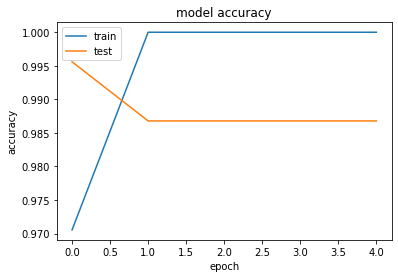

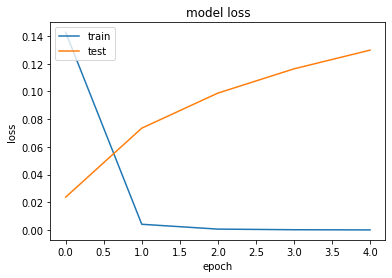

In [84]:

# hiển thị lịch sử đào tạo

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [85]:
model.save('model.h5')
